In [1]:
!pip install igraph

In [2]:
from joblib import dump, load
import sklearn
import pandas as pd
import numpy as np
import warnings
from collections import defaultdict
from igraph import Graph
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
# This function generates the tree plot for the supervised model
# joblib_model_file -> this is the string of the path where the .joblib model file is stored
# le_wrapper -> this is the string of the path where the .joblib le wrapper is stored
# plot_string -> this is the string of user input for the first plot question from the model
# b2000 -> this is the int (0, 1, or 2) for the before 2000 question
# genre_string -> this is the string of user input for the genre question from the model combined with all previous text
# actor_string -> this is the string of user input for the actor question from the model combined with all previous text
# director_string -> this is the string of user input for the director question from the model combined with all previous text
# title -> this is the string of the title for the plot
def generate_tree_plot(joblib_model_file, le_wrapper, plot_string, b2000, genre_string, actor_string, director_string, title):
  # Load the supervised learning model we are using
  pipeline_loaded = load(joblib_model_file)

  # Loading label coder wrapper to convert Movie from ID to Title name
  le_wrapper = load(le_wrapper)

  # function to get the top n movie predictions based on the combined text and released before 200 variable
  def top_n_predictions(combText, rBefore2000, nScores):
    # User input
    new_movie = pd.DataFrame([{
        "combined_text": combText,
        # values for released before 2000: 2 - Don't know , 1 - if the movie is before year 2000 ; 0 - if after year 200
        "released_before_2000": rBefore2000
    }])

    #Prediction using the model
    prediction = pipeline_loaded.predict(new_movie[["combined_text", "released_before_2000"]])

    # convert back to original movie title
    predicted_class = le_wrapper.inverse_transform(prediction)

    # now get the scores for our predictions, sort them, and get the top n scores
    scores = pipeline_loaded.decision_function(new_movie[["combined_text", "released_before_2000"]])
    top_idx = np.argsort(scores, axis=1)[:, -nScores:][:, ::-1]
    top_labels = pipeline_loaded.classes_[top_idx]

    # Get corresponding top-n scores
    top_scores = np.take_along_axis(scores, top_idx, axis=1)

    # Combine labels and scores for each sample
    top_predictions = [
        list(zip(le_wrapper.inverse_transform(labels), score_vals))
        for labels, score_vals in zip(top_labels, top_scores)
    ]

    return top_predictions[0]

  # Now lets get all of our different predictions
  # to start we have the top 8 predictions where the user only gives the plot summary to our model
  top_plot_string = plot_string
  top_plot = top_n_predictions(top_plot_string, 2, 8)
  # next we have the top 6 predictions where the user adds the released before 2000 variable
  top_r_bef = top_n_predictions(top_plot_string, b2000, 6)
  # then we have the top 4 predicitions where the user adds the genre(s) of the movie
  top_genre_string = genre_string
  top_genre = top_n_predictions(top_genre_string, b2000, 4)
  # next is the top 2 predictions where the user adds the lead actor(s) of the movie
  top_actor_string = actor_string
  top_actor = top_n_predictions(top_actor_string, b2000, 2)
  # finally we have the top 1 prediction that the model is guessing when the user adds the director(s)
  top_director_string = director_string
  top_director = top_n_predictions(top_director_string, b2000, 1)

  # also define a list with all the strings in it and the value for the before 2000 question
  string_list = [top_plot_string, top_genre_string, top_actor_string, top_director_string]
  bef_2000_num = 0

  # Now find the difference in each string
  # Initialize a previous string variable and the list for the different strings
  prev_string = ""
  diff_string_list = []

  # For each user input string append the difference when compared to the previous string
  for s in string_list:
    diff_string_list.append(s[len(prev_string):].lstrip())
    prev_string = s
    # Also if we have already handeled the first user input then account for the before 2000 question
    if len(diff_string_list) == 1:
      match bef_2000_num:
        case 0:
          diff_string_list.append("Yes")
        case 1:
          diff_string_list.append("No")
        case 2:
          diff_string_list.append("Not sure")

  # First create the number of children nodes that each node will have in order
  # from the top to bottom (or in this case bottom to top)
  num_chld_nodes = [2,
                    2, 2,
                    2, 1, 1, 2,
                    2, 1, 1, 1, 1, 2,
                    0, 0, 0, 0, 0, 0, 0, 0]

  # Define the edges and the initial node
  edges = []
  # We set this to 1 so we can do some tricky coding in the loop
  curr_node = 1

  # Here we initialize dummy edges to build a placeholder
  # (we need this for coordinates later)
  edges = []
  curr_node = 1
  for parent, count in enumerate(num_chld_nodes):
      for _ in range(count):
          edges.append((parent, curr_node))
          curr_node += 1

  # Create the placeholder graph for coords
  g_temp = Graph(edges=edges, directed=True, n=len(num_chld_nodes))
  layout = g_temp.layout("rt")
  coords = layout.coords


  # Initialize empty lists for our names and scores
  n_names = []
  scores = []

  # Now extract those values from our predictions using this helper function
  def extract_names_score(prediction):
      for ns in prediction:
          n_names.append(ns[0])
          scores.append(round(ns[1], 2))

  # Actually extract names and scores (order matters, remember bottom to top)
  extract_names_score(top_director)
  extract_names_score(top_actor)
  extract_names_score(top_genre)
  extract_names_score(top_r_bef)
  extract_names_score(top_plot)

  # Now we can get the different y-levels for our nodes into a dict
  level_dict = defaultdict(list)
  for idx, (_, y) in enumerate(coords):
      level_dict[y].append(idx)

  # Sort the levels of the dictonary from top to bottom
  sorted_levels = sorted(level_dict.keys(), reverse=True)

  # Now that we have all that information we can build edges only
  # between adjacent levels when names match
  # Start by defining a new edges list
  new_edges = []

  # Then loop through all the sorted levels
  for i in range(len(sorted_levels) - 1):
    # Define which level is above the other
      upper = level_dict[sorted_levels[i]]
      lower = level_dict[sorted_levels[i + 1]]
      # Loop through both levels
      for u in upper:
          for l in lower:
            # If there is a name that is the same in the upper as the lower
              if n_names[u] == n_names[l]:
                # Append
                  new_edges.append((u, l))

  # Now lets create the graph with these new edges
  g = Graph(edges=new_edges, directed=True, n=len(n_names))

  # Assign labels
  g.vs['label'] = n_names

  # Now that that's all finished we can move on to the actual visualization part
  # Start by setting the figsize and the axis for our plot
  plt.figure(figsize=(15, 10))
  ax = plt.gca()

  # Draw edges as we defined in our new graph from the source to target (parent to child)
  for edge in g.es:
      source, target = edge.tuple
      x0, y0 = coords[source]
      x1, y1 = coords[target]
      plt.plot([x0, x1], [y0, y1], color='black', linewidth=1)

  # Now draw the nodes too and set the color/style
  x_crds, y_crds = zip(*coords)
  plt.scatter(x_crds, y_crds, s=1000, color='skyblue', edgecolors='black', zorder=3)

  # These two lines specifically exist for the top two rows of the tree
  # Since there are so many titles they tend to overlap so I basically sort the
  # y level coordinates and take the top level, then for that specific level I
  # create an offset when draing the labels
  lvl_y_crds = sorted(set(y for _, y in coords), reverse=True)

  # Draw labels for each node
  for i, (x, y) in enumerate(coords):
    # If the labels are in that top level
      if y == lvl_y_crds[0] or y==lvl_y_crds[1]:
        # set an offset for ever other node so nothing overlaps
          offset = 0.4 if i % 2 == 0 else 0.2
          plt.text(x, y + offset, n_names[i], ha='center', va='bottom', fontsize=10)
      # otherwise draw as normal
      else:
          plt.text(x, y + 0.3, n_names[i], ha='center', va='bottom', fontsize=10)

  # Draw confidence scores inside nodes
  for i, (x, y) in enumerate(coords):
      plt.text(x, y, str(scores[i]), ha='center', va='center', fontsize=8,
              fontweight='bold', color='darkblue')

  # Set the titles for each of our 5 levels here
  lvl_titles = ['Quick Plot Summary', 'Released before 2000?',
                'What is the genre?', 'Who is the main actor?',
                'Who is the director?']
  # Also set an offset here so there is some distance between the questions and the nodes
  x_min = min(x_crds)
  x_offset = 0.5
  label_x = x_min - x_offset

  # Now draw the level titles as the questions we have asked for each level
  for i in range(5):
      plt.text(label_x, lvl_y_crds[i], lvl_titles[i], ha='right', va='center',
              fontsize=10, fontweight='bold', color='black')

  # Also add the inputs in the same way
  for val in range(5):
      plt.text(label_x, lvl_y_crds[val]-0.2, "User Input: " + diff_string_list[val], ha='right', va='center',
              fontsize=10, color='black')

  # Finalize the styling with axis, padding, and title info
  plt.axis('off')
  plt.tight_layout(pad=2.5)
  plt.title(title, fontsize=16,
            fontweight='bold', y=1.10)
  # Show our plot
  plt.show()

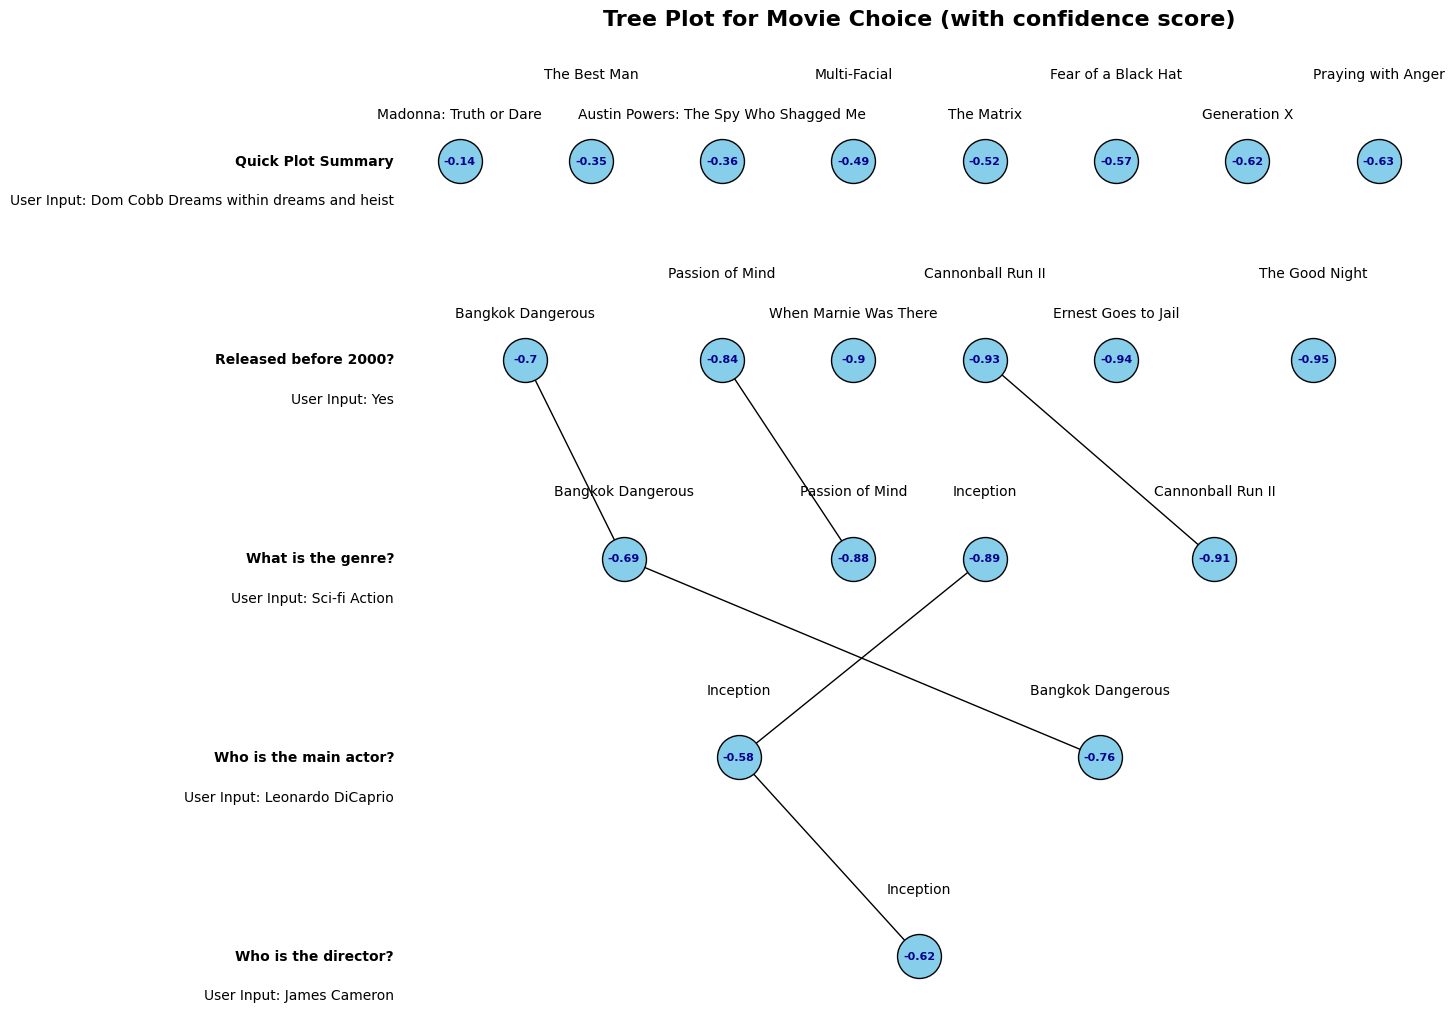

In [4]:
generate_tree_plot("LinearSVC_hypertuned.joblib", "LE_wrapper_xgboost.joblib",
                   "Dom Cobb Dreams within dreams and heist", 0,
                   "Dom Cobb Dreams within dreams and heist Sci-fi Action",
                   "Dom Cobb Dreams within dreams and heist Sci-fi Action Leonardo DiCaprio",
                   "Dom Cobb dreams within dreams and heist Sci-fi Action Leonardo DiCaprio James Cameron",
                   "Tree Plot for Movie Choice (with confidence score)"
                   )